In [1]:
import sys
import os

# Imports from NeuroCurator code base
sys.path.append(os.path.join(os.getcwd(), ".."))

from glob import glob
from qtNeurolexTree import flatten_list, TreeData
from annotation import Annotation
from modelingParameter import NumericalVariable, getParameterTypeFromID

import pandas as pd
import numpy as np

/home/oreilly/Dropbox/code/curator_app/notebooks/.././additionsToNeurolex.csv


In [2]:
annotations = []
for fileName in glob("/home/oreilly/Dropbox/code/curator_app/curator_DB/*.pcr"):
    try:
        annotations.extend(Annotation.readIn(open(fileName, "r", encoding="utf-8", errors='ignore')))
    except:       
        print("Skipping: ", fileName)    
        raise

Incompatibility between in NIFMOL:nifext_8054:Sodium transient fast current. Correcting to BBP_nlx_0003:Sodium transient fast current
Incompatibility between in NIFCELL:sao1813327414:Thalamic reticular nucleus cell. Correcting to NIFCELL:nifext_45:Thalamic reticular nucleus cell
Incompatibility between in NIFMOL:nifext_8054:Potassium delayed rectifier. Correcting to BBP_nlx_0006:Potassium delayed rectifier
Incompatibility between in NIFCELL:sao1813327414:Thalamic reticular nucleus cell. Correcting to NIFCELL:nifext_45:Thalamic reticular nucleus cell
Incompatibility between in NIFMOL:nifext_8054:Sodium transient fast current. Correcting to BBP_nlx_0003:Sodium transient fast current
Incompatibility between in NIFCELL:sao1813327414:Thalamic reticular nucleus cell. Correcting to NIFCELL:nifext_45:Thalamic reticular nucleus cell
Incompatibility between in NIFMOL:nifext_8054:Potassium delayed rectifier. Correcting to BBP_nlx_0006:Potassium delayed rectifier
Incompatibility between in NIFCELL

In [3]:
annotData = {"Type":[], "Nb. of param.":[], "Text":[]}
for annot in annotations:
    annotData["Type"].append(annot.type)
    annotData["Nb. of param."].append(len(annot.parameters))
    annotData["Text"].append(annot.text)
annotData = pd.DataFrame(annotData)
    

In [4]:
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 1000
print(len(annotData))
#annotData

246


In [5]:
len(np.unique([annot.pubId for annot in annotations]))

40

In [6]:
parameters = flatten_list([[(param, annot) for param in annot.parameters] for annot in annotations])
parameters, paramAnnot = zip(*parameters)

paramDescType = [param.description.type for param in parameters]
paramTypes = [getParameterTypeFromID(param.description.depVar.typeId) for param in parameters]
paramTypeNames = [param.name for param in paramTypes]
paramValues = [param.description.depVar.values.text() if isinstance(param.description.depVar, NumericalVariable)
                                               else np.nan for param in parameters]

paramTypeIds = [param.ID for param in paramTypes]
reqTags      = [[tag.name for tag in param.requiredTags] if len(param.requiredTags) else "" for param in parameters]


paramContext = [annot.getContext(dbPath="../curator_DB") for annot in paramAnnot]
paramText = [annot.text for annot in paramAnnot]
pubId = [annot.pubId for annot in paramAnnot]

print(len(paramTypes))
paramValues
df = pd.DataFrame({"Param":paramTypeNames, "Values":paramValues, 
              "ID":paramTypeIds, "Req. Tag.":reqTags, "text":paramText, 
               "context":paramContext, "pubID":pubId}).sort_values("ID")

211


In [7]:
# For Renaud
ids = (df["ID"].value_counts()).index[df["ID"].value_counts() > 5]
df = df[np.in1d(df["ID"], ids)]
df = df[df["context"] != ""]
df.to_csv("params.csv", index=False, columns=["Param","pubID", "Values", "text", "context"])

In [8]:
from annotationSearch import ParameterSearch, ConditionAtom
from qtNeurolexTree import TreeData

searcher = ParameterSearch()
searcher.setSearchConditions(ConditionAtom("Parameter name", "conductance_ion_curr_max"))
searcher.expandRequiredTags = True
searcher.onlyCentralTendancy = True

# searcher.resultFields.
# parameterResultFields  = ["Required tag names", "Result type", "Values", "Parameter name", "Parameter type ID", "Parameter instance ID", "Unit"] 



resultDF = searcher.search()
del resultDF["obj_parameter"]
del resultDF["obj_annotation"]
del resultDF["Context"]
del resultDF["Parameter instance ID"]
del resultDF["Text"]
del resultDF["Parameter type ID"]
del resultDF["Result type"]

print(resultDF)

#%matplotlib inline
#import seaborn as sns
#g = sns.violinplot(x="Transmembrane ionic current", y="Values", data=result)


/home/oreilly/Dropbox/code/curator_app/notebooks/.././additionsToNeurolex.csv
Incompatibility between in NIFMOL:nifext_8054:Sodium transient fast current. Correcting to BBP_nlx_0003:Sodium transient fast current
Incompatibility between in NIFCELL:sao1813327414:Thalamic reticular nucleus cell. Correcting to NIFCELL:nifext_45:Thalamic reticular nucleus cell
Incompatibility between in NIFMOL:nifext_8054:Potassium delayed rectifier. Correcting to BBP_nlx_0006:Potassium delayed rectifier
Incompatibility between in NIFCELL:sao1813327414:Thalamic reticular nucleus cell. Correcting to NIFCELL:nifext_45:Thalamic reticular nucleus cell
Incompatibility between in NIFMOL:nifext_8054:Sodium transient fast current. Correcting to BBP_nlx_0003:Sodium transient fast current
Incompatibility between in NIFCELL:sao1813327414:Thalamic reticular nucleus cell. Correcting to NIFCELL:nifext_45:Thalamic reticular nucleus cell
Incompatibility between in NIFMOL:nifext_8054:Potassium delayed rectifier. Correcting 

In [9]:
import quantities as pq #q.rescale('US_survey_acre')

specificConductances = []
conductances = []
isSpecific = []
allConductances = []

for v, u in zip(resultDF["Values"], resultDF["Unit"]):
    try:
        value = pq.Quantity(v, u).rescale('S/cm**2')
        specificConductances.append(value)
        isSpecific.append(True)
    except:
        value = pq.Quantity(v, u).rescale('nS')
        conductances.append(value)
        isSpecific.append(False)

    allConductances.append(float(value))
        
resultDF["ValuesNorm"] = np.log10(allConductances)
resultDF["isSpecific"] = isSpecific 
print(resultDF["ValuesNorm"][resultDF["isSpecific"]])

0    -1.221849
1    -1.619789
2    -4.000000
3    -2.698970
4    -2.397940
6    -1.301030
7    -5.000000
9    -3.602060
10   -2.096910
11   -2.677781
12   -0.468521
13   -2.200659
14   -5.522879
15   -2.522879
16   -0.744727
17   -4.823909
19   -4.154902
20   -1.958607
22   -3.823909
23   -2.292430
24   -1.000000
25   -1.301030
26   -2.698970
27   -2.221849
28   -4.698970
29   -2.795880
30   -3.522879
31   -4.920819
33   -2.958607
34   -0.397940
35   -1.000000
36   -0.744727
37   -1.096910
38   -1.000000
39   -2.000000
40   -1.000000
41   -5.070581
42   -2.397940
43   -1.000000
44   -0.522879
45   -1.619789
46   -2.200659
47   -2.698970
48   -4.522879
49   -3.823909
50   -2.000000
51   -2.259637
52   -3.000000
54   -4.657577
55   -1.301030
56   -5.259637
57   -3.301030
Name: ValuesNorm, dtype: float64


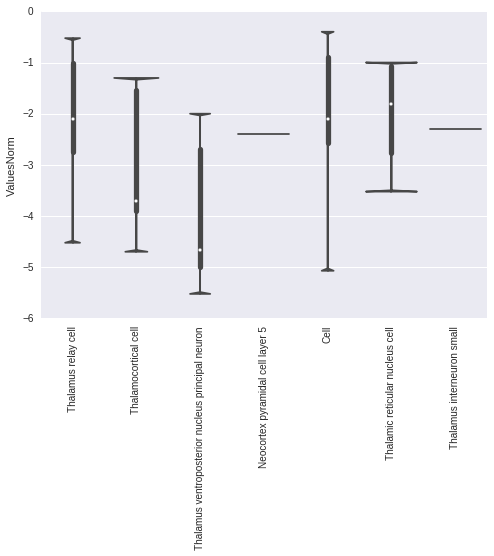

In [10]:
%matplotlib inline
import seaborn as sns
g = sns.violinplot(x="Cell", y="ValuesNorm", data=resultDF[resultDF["isSpecific"]], bw=0.00001)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_xlabel("")
#g.set_yscale("log")

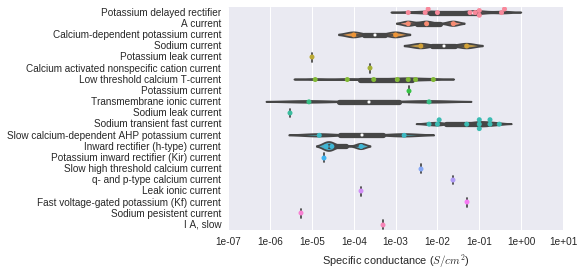

In [11]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
g = sns.violinplot(y="Transmembrane ionic current", x="ValuesNorm", 
                   data=resultDF[resultDF["isSpecific"]], bw=0.25)
g = sns.swarmplot(y="Transmembrane ionic current", x="ValuesNorm", 
                   data=resultDF[resultDF["isSpecific"]])
g.set_yticklabels(g.get_yticklabels())#, rotation=90)
g.set_ylabel("")
g.set_xlabel("Specific conductance ($S/cm^2$)")

values  = g.get_xticks()
labels = [('%.0e' % 10**nb) for nb in values]
g.set_xticklabels(labels) #x, labels, rotation='vertical')
plt.savefig('example_currents.png', bbox_inches='tight', transparent=True, dpi=200)
#g.set_yscale("log")

In [12]:
from annotationSearch import ParameterSearch, ConditionAtom
from qtNeurolexTree import TreeData

searcher = ParameterSearch()
searcher.setSearchConditions(ConditionAtom("Parameter name", "resting_membrane_potential"))
searcher.expandRequiredTags = True
searcher.onlyCentralTendancy = True

# searcher.resultFields.
# parameterResultFields  = ["Required tag names", "Result type", "Values", "Parameter name", "Parameter type ID", "Parameter instance ID", "Unit"] 



resultDF2 = searcher.search()
del resultDF2["obj_parameter"]
del resultDF2["obj_annotation"]
del resultDF2["Context"]
del resultDF2["Parameter instance ID"]
del resultDF2["Text"]
del resultDF2["Parameter type ID"]
del resultDF2["Result type"]

print(resultDF2)

#%matplotlib inline
#import seaborn as sns
#g = sns.violinplot(x="Transmembrane ionic current", y="Values", data=result)


/home/oreilly/Dropbox/code/curator_app/notebooks/.././additionsToNeurolex.csv
Incompatibility between in NIFMOL:nifext_8054:Sodium transient fast current. Correcting to BBP_nlx_0003:Sodium transient fast current
Incompatibility between in NIFCELL:sao1813327414:Thalamic reticular nucleus cell. Correcting to NIFCELL:nifext_45:Thalamic reticular nucleus cell
Incompatibility between in NIFMOL:nifext_8054:Potassium delayed rectifier. Correcting to BBP_nlx_0006:Potassium delayed rectifier
Incompatibility between in NIFCELL:sao1813327414:Thalamic reticular nucleus cell. Correcting to NIFCELL:nifext_45:Thalamic reticular nucleus cell
Incompatibility between in NIFMOL:nifext_8054:Sodium transient fast current. Correcting to BBP_nlx_0003:Sodium transient fast current
Incompatibility between in NIFCELL:sao1813327414:Thalamic reticular nucleus cell. Correcting to NIFCELL:nifext_45:Thalamic reticular nucleus cell
Incompatibility between in NIFMOL:nifext_8054:Potassium delayed rectifier. Correcting 

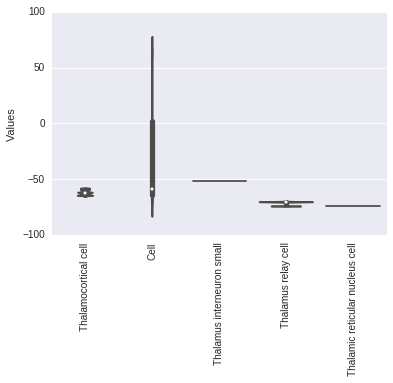

In [13]:
%matplotlib inline
import seaborn as sns
g = sns.violinplot(x="Cell", y="Values", data=resultDF2, bw=0.1)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_xlabel("")
#g.set_yscale("log")